In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas
import re

In [5]:
def get_lemma_distribution(file_name):
    lemmas=[]
    pattern = re.compile('http://en.wikipedia.org/wiki/[a-z,A-z,_]+$')
    for line in open(file_name):
        url=line.strip().split(' ')[2]
        if not pattern.match(url):
            continue
        lemma=url[url.rfind('/')+1:]
        if '.' in lemma:
            continue
        lemmas.append(lemma)
    return lemmas

In [6]:
visit_count=dict()
f=open('./data/list2.txt').readlines()[1:]
for line in tqdm(f[:500]):
    line=line.strip()[:-3]
    lemmas=get_lemma_distribution('./data/only_lemma/%s'%line)
    for entry in lemmas:
        try:
            visit_count[entry]+=1
        except:
            visit_count[entry]=1

In [9]:
visit_count_df=pandas.DataFrame(list(visit_count.items()),columns=['Entry','Visit Count'])

In [10]:
visit_count_df=visit_count_df.to_csv('./data/entry_visit_count.csv',index=False)

In [42]:
visit_count_df=pandas.read_csv('./data/entry_visit_count.csv')

In [43]:
visit_count_df=visit_count_df.dropna(axis=0, how='any')

In [44]:
def get_iqr(array):
    q1,q3=np.percentile(array,[25,75])
    return q1,q3,q3-q1

In [45]:
entry_len_Q1,entry_len_Q3,entry_len_iqr=get_iqr(entry_len.values)

In [46]:
entry_len_Q1,entry_len_Q3,entry_len_iqr

(10.0, 19.0, 9.0)

In [47]:
visit_count_df=visit_count_df[entry_len<entry_len_Q3+1.5*entry_len_iqr]

In [48]:
visit_count_df.head()

,Entry,Visit Count
0,The_Drawer_Boy,21
1,Fire_On_The_Moon,2
2,Sven_Broman,1
3,Alegaesia,1
5,Leo_Echegaray,23


In [49]:
page_len=pandas.read_csv('./data/pagelens/page_len.csv',sep=';')

In [50]:
page_len.head()

,page_title,page_counter,page_len
0,AmericanSamoa,0,48
1,AppliedEthics,0,49
2,AccessibleComputing,0,57
3,Anarchism,5252,67759
4,AfghanistanHistory,5,57


/home/xuanli2/penv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


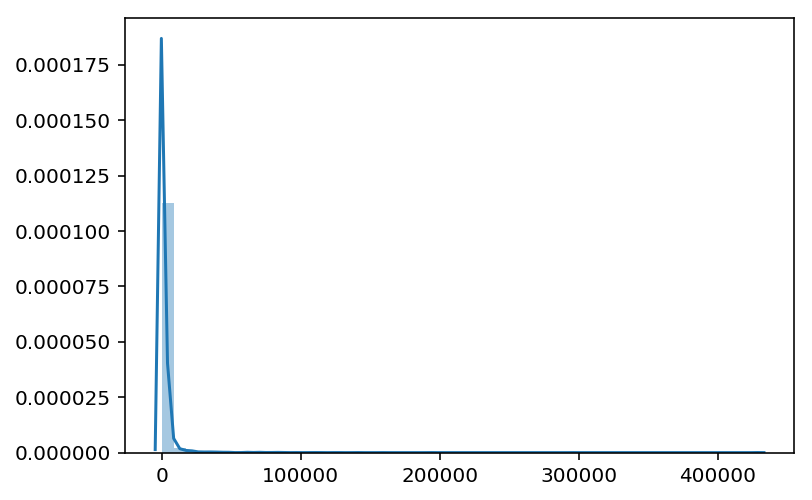

In [51]:
sns.distplot(np.random.choice(page_len['page_len'].values,10000))

In [52]:
title_counts=page_len['page_title'].value_counts()

In [53]:
page_len=page_len[page_len['page_title'].isin(title_counts[title_counts<2].index)]

In [100]:
merged_df=pandas.merge(page_len, visit_count_df, left_on="page_title",right_on="Entry")

In [106]:
filtered_df=merged_df[merged_df['page_len']<merged_df["page_len"].quantile(0.99)]

In [107]:
filtered_df=filtered_df[filtered_df['Visit Count']<filtered_df["Visit Count"].quantile(0.99)]

In [103]:
filtered_df=filtered_df[filtered_df['page_len']>100]

In [108]:
filtered_df['page_len'].max()

6631

In [109]:
filtered_df['Visit Count'].max()

255

In [138]:
filtered_df['bin'] = pandas.cut(filtered_df['page_len'], range(0,filtered_df['page_len'].max(),500))

In [139]:
filtered_df.head()

,page_title,page_counter,page_len,Entry,Visit Count,bin,log_visit_count
0,AmericanSamoa,0,48,AmericanSamoa,2,"(0, 500]",0.693147
1,AppliedEthics,0,49,AppliedEthics,4,"(0, 500]",1.386294
2,AccessibleComputing,0,57,AccessibleComputing,4,"(0, 500]",1.386294
3,AfghanistanHistory,5,57,AfghanistanHistory,2,"(0, 500]",0.693147
4,AfghanistanGeography,0,59,AfghanistanGeography,4,"(0, 500]",1.386294


In [140]:
filtered_df['log_visit_count']=np.log(filtered_df['Visit Count'].values)

In [141]:
group=filtered_df.groupby('bin').mean()

In [142]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

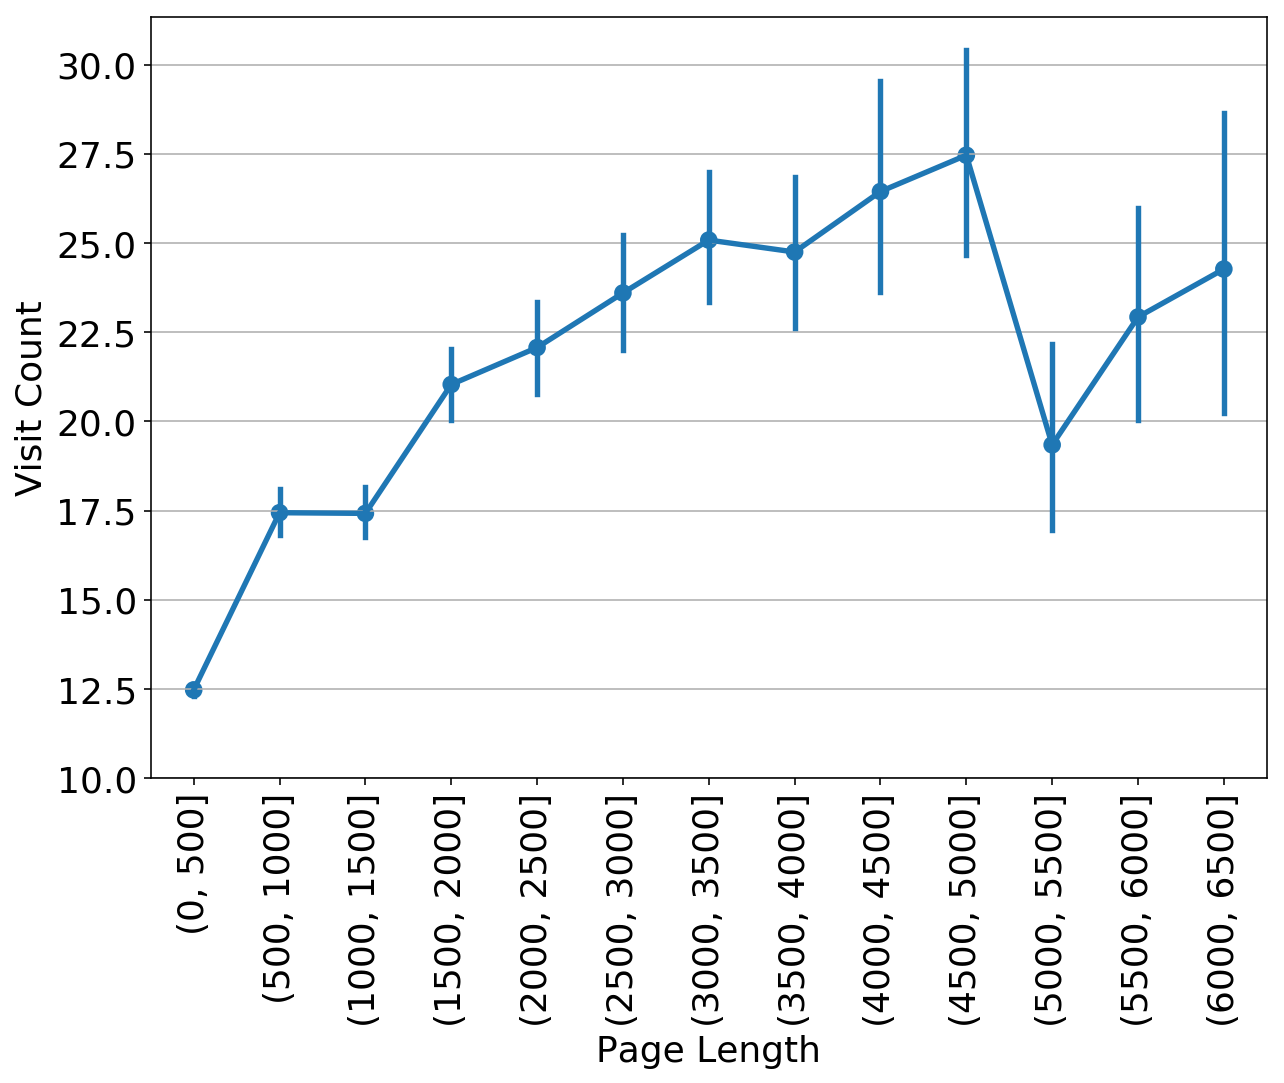

In [146]:
plt.figure(figsize=(10,7))
sns.pointplot(x="bin", y="Visit Count", data=filtered_df.sample(frac=0.1))
plt.xticks(rotation='vertical')
plt.xlabel('Page Length')
plt.grid(axis='y')
plt.ylim((10,None))
plt.savefig('./plots/visit_count_vs_page_length.pdf')
plt.show()